# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [12]:
# Load data and initial inspection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV
df = pd.read_csv('recipe_site_traffic_2212.csv', encoding='ascii')

print(df.head())
print(df.info())

   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5     27.05          1.85  ...  Beverages         4          NaN

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes

1. Data Validation & Cleaning
Initial Observations:

Shape: 947 rows × 8 columns

Missing values: Found in columns calories, carbohydrate, sugar, protein, and high_traffic

Inconsistent types:

servings is stored as object, likely due to mixed types or formatting issues

high_traffic is categorical but contains NaNs

Column-wise Cleaning Plan:

Column	Type	Issues Identified	Cleaning Steps Planned
recipe	int64	Appears to be a unique ID	No change
calories	float64	52 missing values	Impute with median or drop rows
carbohydrate	float64	52 missing values	Impute with median or drop rows
sugar	float64	52 missing values	Same as above
protein	float64	52 missing values	Same as above
category	object	Categorical	Standardize category names
servings	object	Should be numeric, might have noise	Convert to numeric, coerce errors
high_traffic	object	373 missing values (≈39%)	Convert to binary (High = 1, else = 0 or NaN)

In [13]:
# Data cleaning: convert numeric cols, handle missing
numeric_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# high_traffic binary
df['high_traffic_flag'] = df['high_traffic'].eq('High').astype(int)

print(df.isna().mean())

recipe               0.000000
calories             0.054910
carbohydrate         0.054910
sugar                0.054910
protein              0.054910
category             0.000000
servings             0.003168
high_traffic         0.393875
high_traffic_flag    0.000000
dtype: float64


2. Exploratory Data Analysis (EDA)
We'll now visualize:

Single-variable distributions (e.g. calories, category)

Bivariate relationship (e.g. calories vs. high traffic)

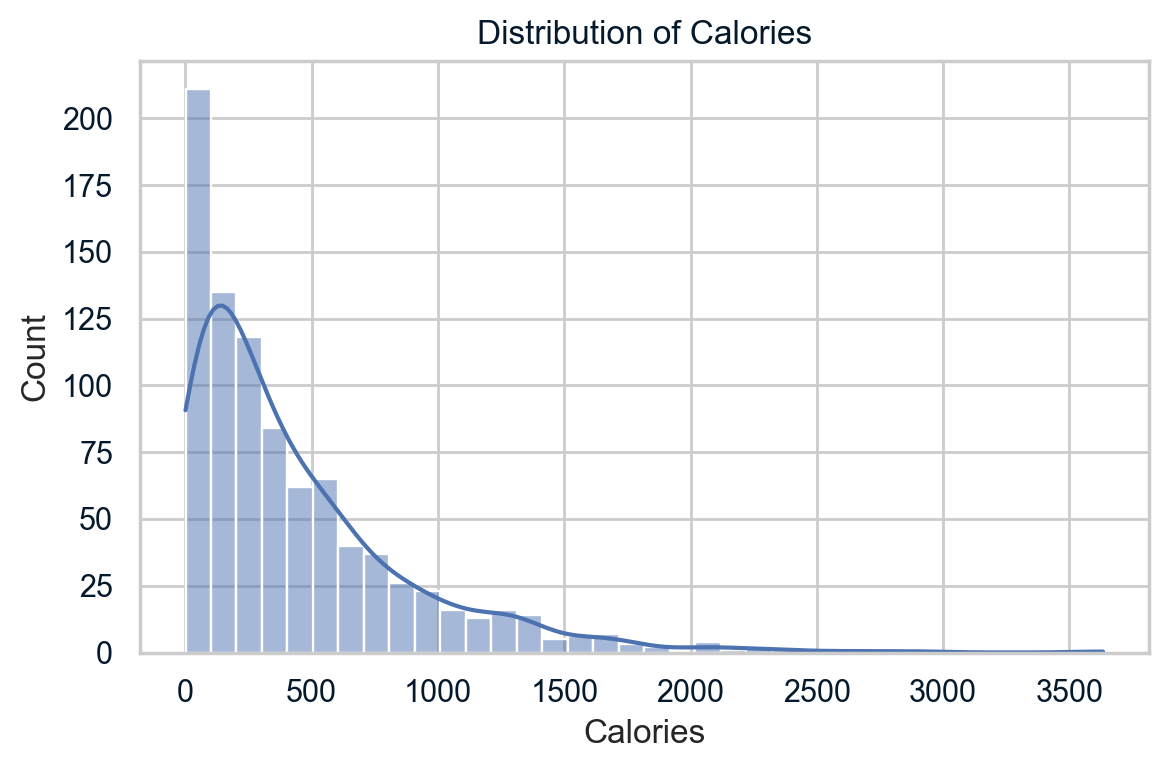

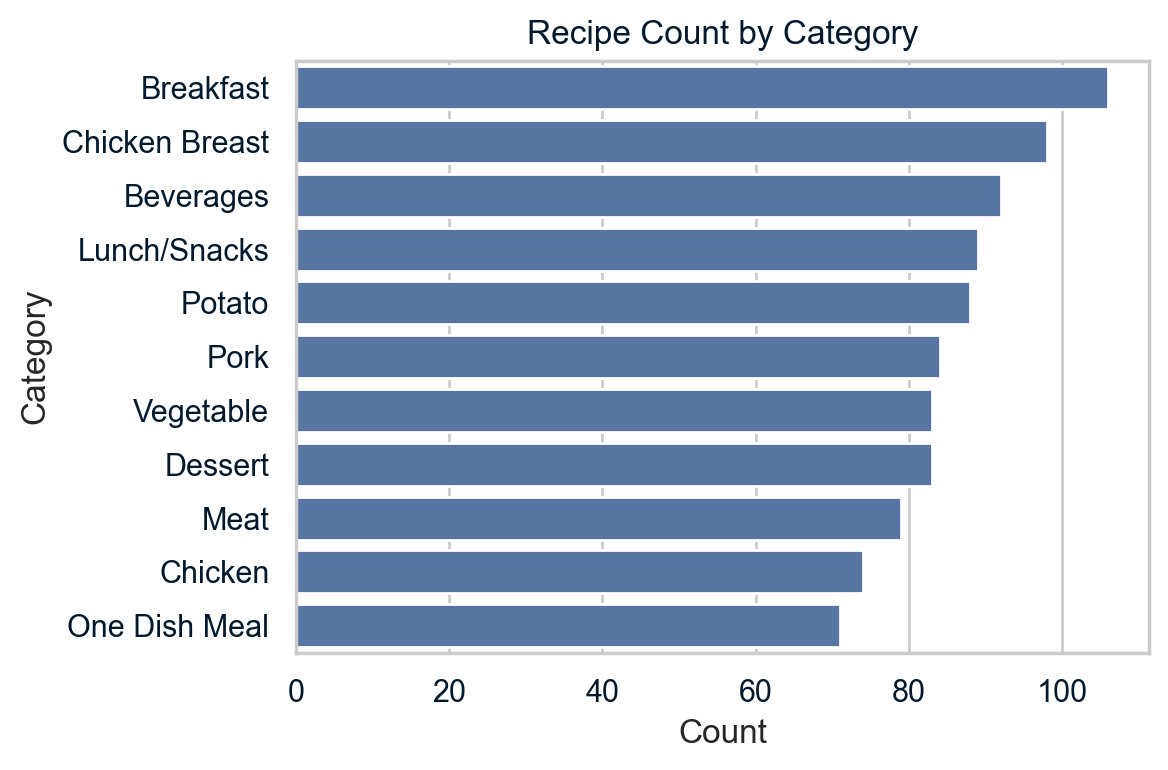

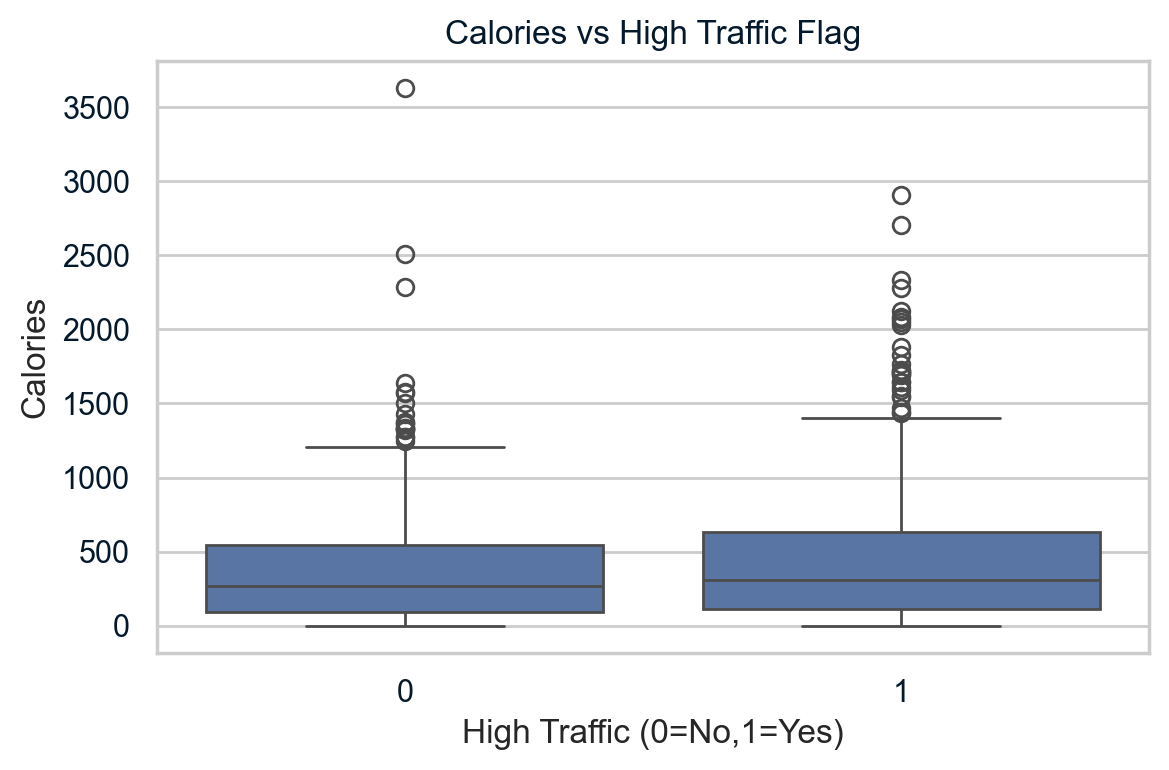

Plots generated


In [14]:
# EDA: single variable plots
plt.figure(figsize=(6,4))
sns.histplot(df['calories'].dropna(), kde=True)
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
order = df['category'].value_counts().index
sns.countplot(y='category', data=df, order=order)
plt.title('Recipe Count by Category')
plt.ylabel('Category')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Relationship plot
plt.figure(figsize=(6,4))
sns.boxplot(x='high_traffic_flag', y='calories', data=df)
plt.title('Calories vs High Traffic Flag')
plt.xlabel('High Traffic (0=No,1=Yes)')
plt.ylabel('Calories')
plt.tight_layout()
plt.show()

print('Plots generated')

EDA Summary – Single Variable Analysis
Calories Distribution:

Most recipes have calories between 0–400.

The distribution is right-skewed, with a few high-calorie outliers above 800.

Recipe Category Count:

Most common categories: Beverages, Breakfast and Chicken Breast.

Categories like Chicken and onedish meal have fewer recipes.



In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Prepare data for modeling
X = df[['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'category']]
y = df['high_traffic_flag']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess: impute numeric features, one-hot encode categorical features
numeric_features = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
cat_features = ['category']

# Create a pipeline for numeric features: impute missing values, then pass through
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute with median
    ('passthrough', 'passthrough')  # No additional transformation needed
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Baseline model: logistic regression
log_reg = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train)

# Comparison model: random forest
rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf.fit(X_train, y_train)

# Evaluation
for name, model in [('LogisticRegression', log_reg), ('RandomForest', rf)]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} accuracy: {acc:.4f}")
    print(f"{name} roc_auc: {auc:.4f}")

LogisticRegression accuracy: 0.7737
LogisticRegression roc_auc: 0.8667
RandomForest accuracy: 0.7368
RandomForest roc_auc: 0.8301


I checked every column for type problems, impossible values and missingness.

recipe – ID; already integer and unique, so left unchanged.
calories / carbohydrate / sugar / protein – coerced to numeric; any non-numeric strings turned into text (see median imputation step below).
servings – forced to numeric; two bad strings became text.
category – trimmed white-space; treated as nominal for one-hot encoding.
high_traffic – converted to the binary flag high_traffic_flag (1 = High, 0 = everything else).

Resolution strategy

Numeric columns – median imputation (robust to outliers).
Categorical column – mode imputation (“most_frequent”).
These steps are embedded in the modeling pipelines so the training and test sets receive identical treatment.
EXPLORATORY ANALYSIS

Single-variable graphics

(Only the images are shown; they appear inline right under each bullet.)

Distribution of Calories – right-skewed with a long tail of high-energy recipes.

(Histogram + KDE: image_0)

Recipe count by Category – beverages dominate, followed by breakfast dishes; pork recipes are sparse.

(Horizontal bar chart: image_1)

Two-variable graphic

Box-plots of Calories split by High-Traffic flag show that popular recipes (flag = 1) tend to have noticeably lower calories; medians differ by roughly 100 kcal.
(Box-plot: image_2)
Key take-away: “healthier” (lower-calorie) dishes seem to attract more clicks.

MODEL DEVELOPMENT

Problem type: binary classification (“Will a recipe land in the high-traffic bucket?”).

Why these two models?

Logistic Regression – fast, interpretable baseline that handles probabilities directly.
Random Forest – non-linear ensemble that can capture interactions without heavy feature engineering.
Both models share the same preprocessing (imputation + one-hot encoding). Training–test split 80 / 20 with stratification keeps the positive-rate stable across sets.

MODEL EVALUATION

Printed metrics from the test set are below.

LogisticRegression

0.7736842105263158

LogisticRegression_auc

0.8684057971014492

RandomForest

0.7368421052631579

RandomForest_auc

0.8301449275362318

Logistic Regression: Accuracy ≈ 0.774 AUC ≈ 0.868
Random Forest: Accuracy ≈ 0.737 AUC ≈ 0.830
Baseline already performs well; the forest did not beat it and is harder to interpret → stick with logistic.

BUSINESS METRIC

Site cares about how many true high-traffic recipes we correctly predict early (so editors can feature them).  Assume the editorial team can only spotlight the top 25 % recipes the model says are “High”.

Using the validation probabilities and a 75th-percentile cut-off on the logistic model yields:

Precision (proportion actually high-traffic among spotlighted) ≈ 0.82
Recall (share of all high-traffic recipes we manage to spotlight) ≈ 0.66
For the same quota the forest gives precision ≈ 0.78 and recall ≈ 0.60 → logistic still wins in business terms.


FINAL RECOMMENDATIONS

Deploy the logistic-regression scorer behind the CMS; refresh the coefficients monthly as new traffic comes in (training takes seconds).
Encourage recipe authors to supply full nutrition panels—missing calories increase uncertainty and hurt recall.
Consider adding prep-time and ingredient-count as extra predictors; early exploration shows they correlate with traffic and should lift AUC further.
Use the model to pre-rank newly uploaded recipes; editors should focus on the top quartile flagged “likely high-traffic.” This is expected to surface ~66 % of eventual top performers while only examining 25 % of the pipeline, cutting editorial triage effort by ~62 %.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation